In [36]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../scripts")
import evaluate
import utils
import tensorflow as tf
import numpy as np
# import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os
import saliency_embed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
testset, targets = evaluate.collect_whole_testset('../data/15_ATAC_chr8/', coords=True)
np_C, np_X, np_Y = utils.convert_tfr_to_np(testset)

In [3]:
# load and get model layer
run_path = glob.glob('../../wandb/*/run-20211023_095131-w6okxt01')[0]

layer = -3
model, bin_size = utils.read_model(run_path, compile_model=False)
aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

In [23]:
threshold = 2
cell_line = 13
print(targets[cell_line])
thresholded_C, thresholded_X, thresholded_Y = utils.threshold_cell_line_np(np_C, 
                                                                           np_X, 
                                                                           np_Y, 
                                                                           cell_line, 
                                                                           more_than=threshold)
idr_class = saliency_embed.label_idr_peaks(thresholded_C, cell_line, bedfile1='../data/15_ATAC_chr8/sequences.bed', 
                                           bedfile2='../data/cell_line_specific_test_sets/cell_line_13/complete/peak_centered/i_2048_w_1.bed', 
                                           fraction_overlap=0.5)
predictions = utils.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)
interm_representations = utils.predict_np(thresholded_X, aux_model, batch_size=32, reshape_to_2D=True)

thresholded_Y.shape

PC-3


2022-03-03 10:35:46.133002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-03-03 10:35:49.506926: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(23346, 2048)

In [24]:
embeddings = saliency_embed.get_embeddings(interm_representations)
embeddings['IDR'] = idr_class
embeddings['cell line'] = targets[cell_line]

In [25]:
embeddings.to_csv('tutorial_outputs/UMAP_embeddings.csv', index=None)

In [26]:
# slice different parts of the seamonster
colorblind_pallete = ["#000000","#004949","#009292","#ffb6db", #"#ff6db6",
                     "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
                     "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

conditions = {'left IDR': saliency_embed.select(embeddings, upper_lim_1=-1, lower_lim_2=5, idr='y'),
              'right IDR': saliency_embed.select(embeddings, lower_lim_1=4, upper_lim_2=6, idr='y'),
              'top IDR': saliency_embed.select(embeddings, lower_lim_1=3, lower_lim_2=11, idr='y'),
              'center IDR': saliency_embed.select(embeddings, lower_lim_1=1, 
                                   upper_lim_1=3, lower_lim_2=5, upper_lim_2=8, idr='y')
             }

# add splice labels
labels = np.array(['IDR' if e else 'non-IDR' for e in embeddings['IDR'].values])
labels = labels.astype('U25')
color_correspondance = {'non-IDR':'#B2BABB', 
                        'IDR':'#FF5733'}
for i, (l, c) in enumerate(conditions.items()):
    print(l)
    labels[c] = l
    color_correspondance[l] = colorblind_pallete[i+1]
embeddings['labels'] = labels

Choosing only IDR
Choosing only IDR
Choosing only IDR
Choosing only IDR
left IDR
right IDR
top IDR
center IDR


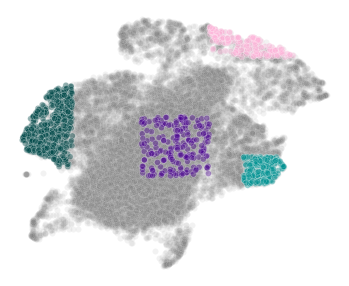

In [29]:
fig, ax = plt.subplots(1,figsize=[6,5])

sns.scatterplot(data=embeddings,
               x='UMAP 1', y='UMAP 2',
               alpha=0.1, 
               color='grey',
               ax=ax)
df = embeddings.sort_values('labels')
df = df[(df['labels']!='IDR')&(df['labels']!='non-IDR')]
df.to_csv('tutorial_outputs/df_labelled_emb.csv', index=None)
sns.scatterplot(data=df,
               x='UMAP 1', y='UMAP 2',
               hue='labels', alpha=0.4, 
               palette=color_correspondance,
               ax=ax)
ax.get_legend().remove()
ax.set_axis_off()

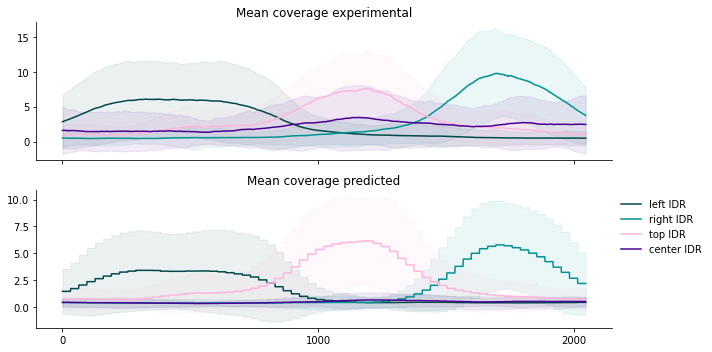

In [34]:
fig, axs = plt.subplots(2,1,figsize=[10,5], sharex=True)
data_and_labels_true = [(thresholded_Y[c], l, color_correspondance[l]) for l, c in conditions.items()]
saliency_embed.plot_mean_coverages(data_and_labels_true, axs[0])

data_and_labels_pred = [(np.repeat(predictions[:,:,cell_line][c], bin_size, axis=1), l, color_correspondance[l]) for l, c in conditions.items()]
saliency_embed.plot_mean_coverages(data_and_labels_pred, axs[1])
for i, title in enumerate(["Mean coverage experimental", 'Mean coverage predicted']):    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(title)
    
axs[1].legend(loc='upper left', bbox_to_anchor=(1,1), 
                  prop={'size': 10}, frameon=False)
axs[1].set_xticks([0, 1000, 2000]) 
plt.tight_layout()

tutorial_outputs/saliency_maps/left IDR.svg
tutorial_outputs/saliency_maps/right IDR.svg
tutorial_outputs/saliency_maps/top IDR.svg
tutorial_outputs/saliency_maps/center IDR.svg


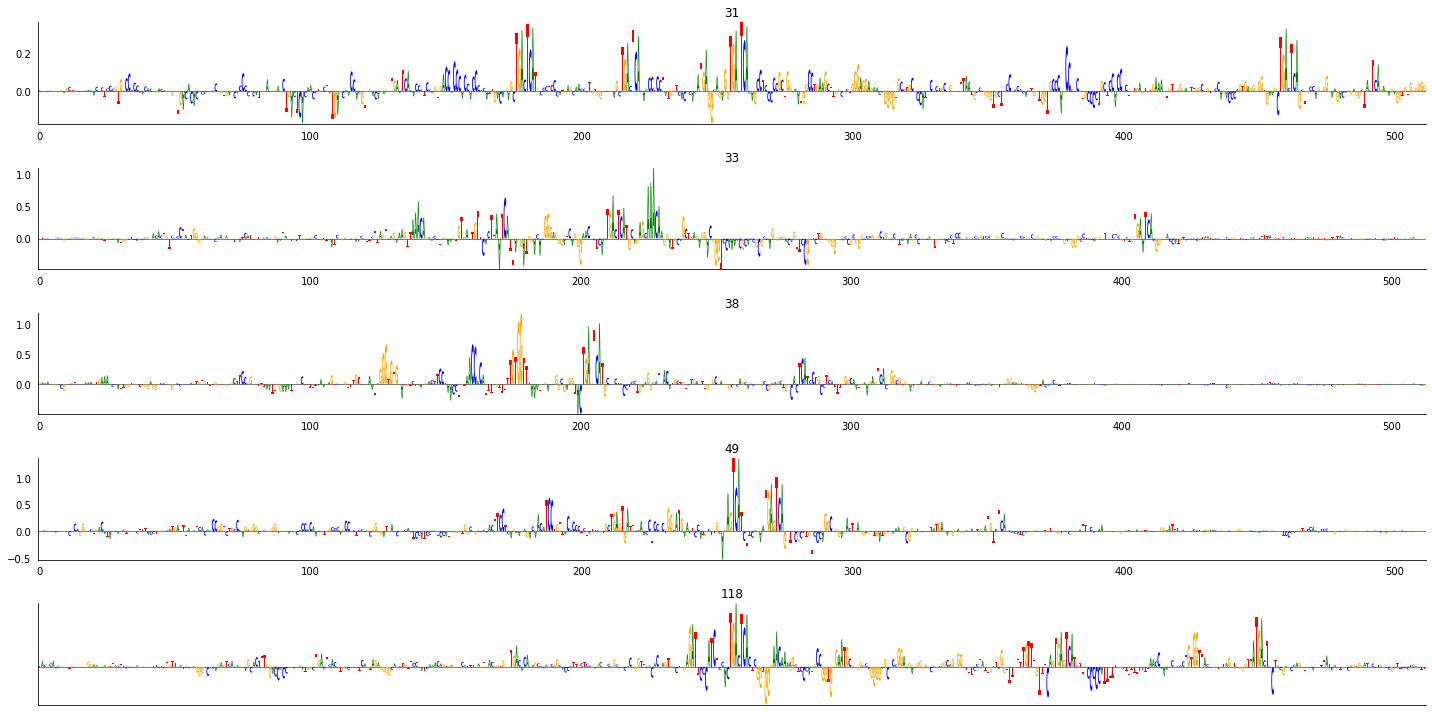

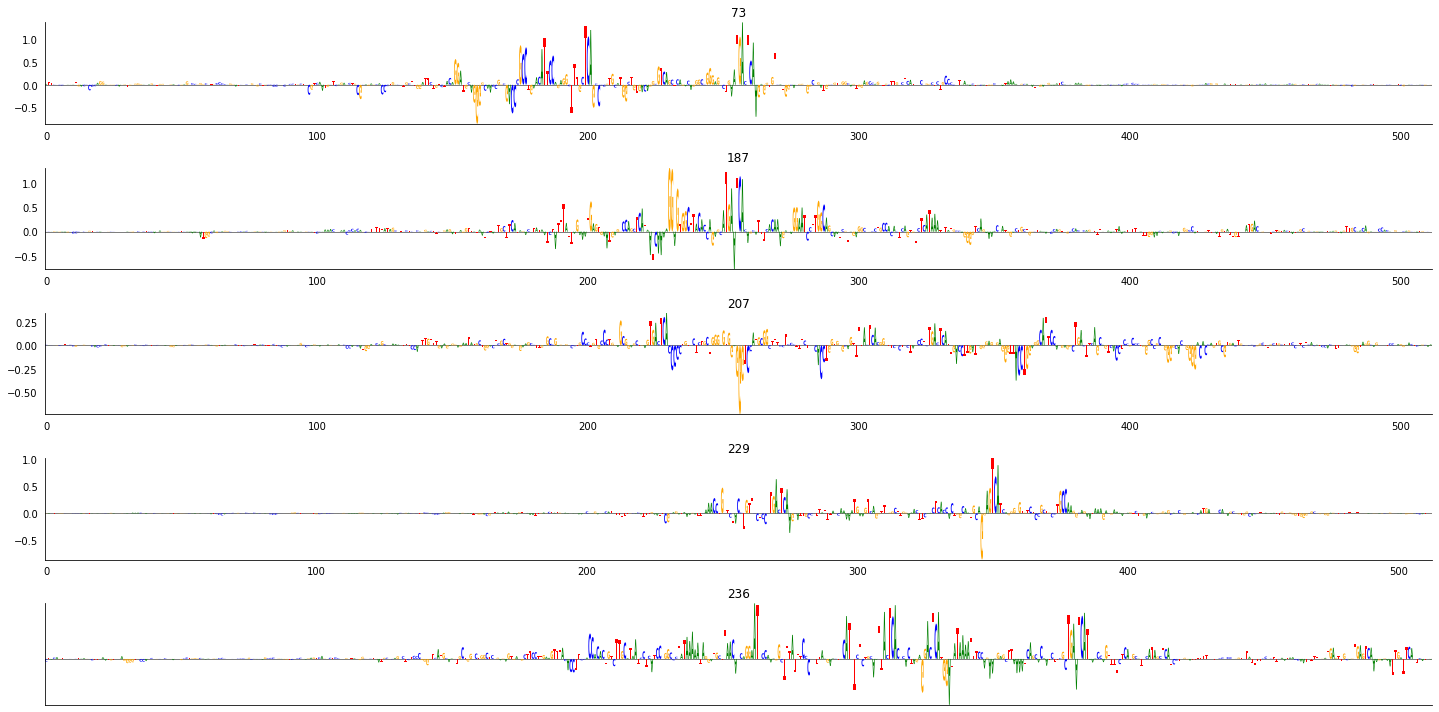

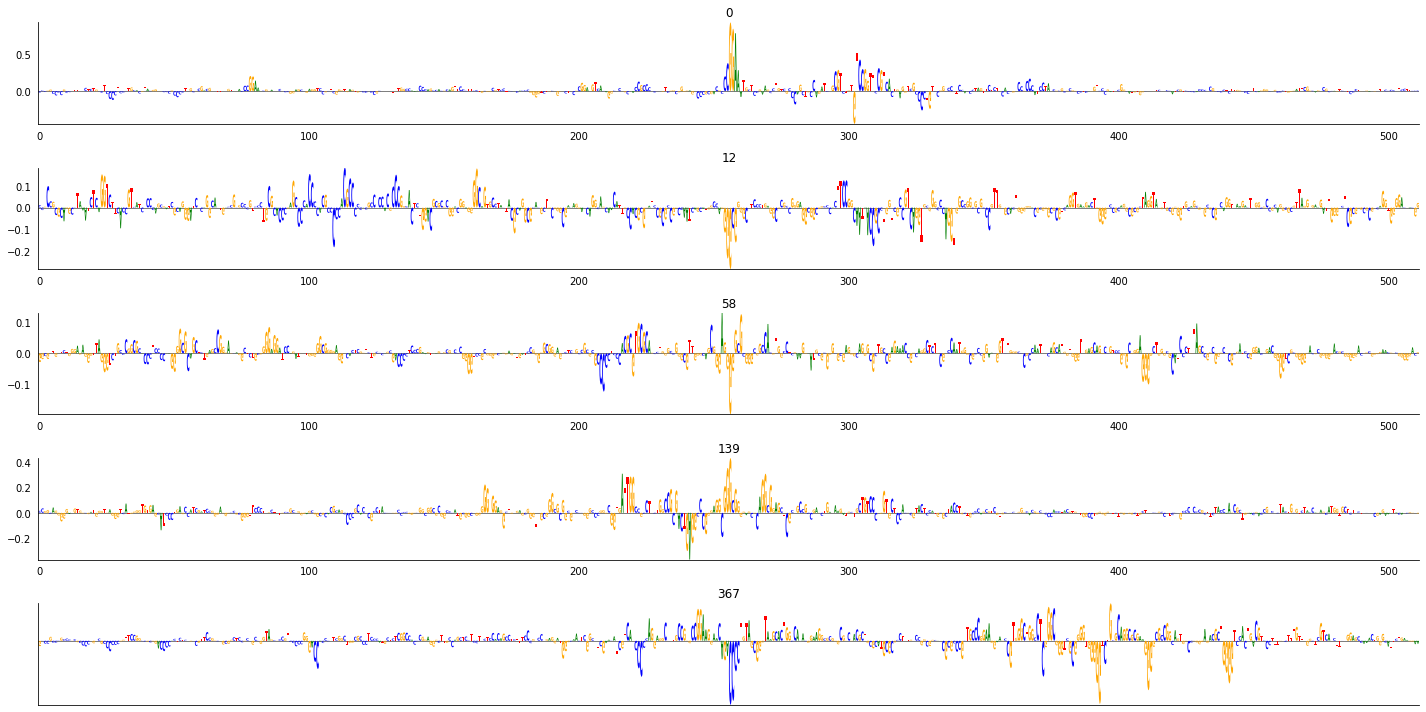

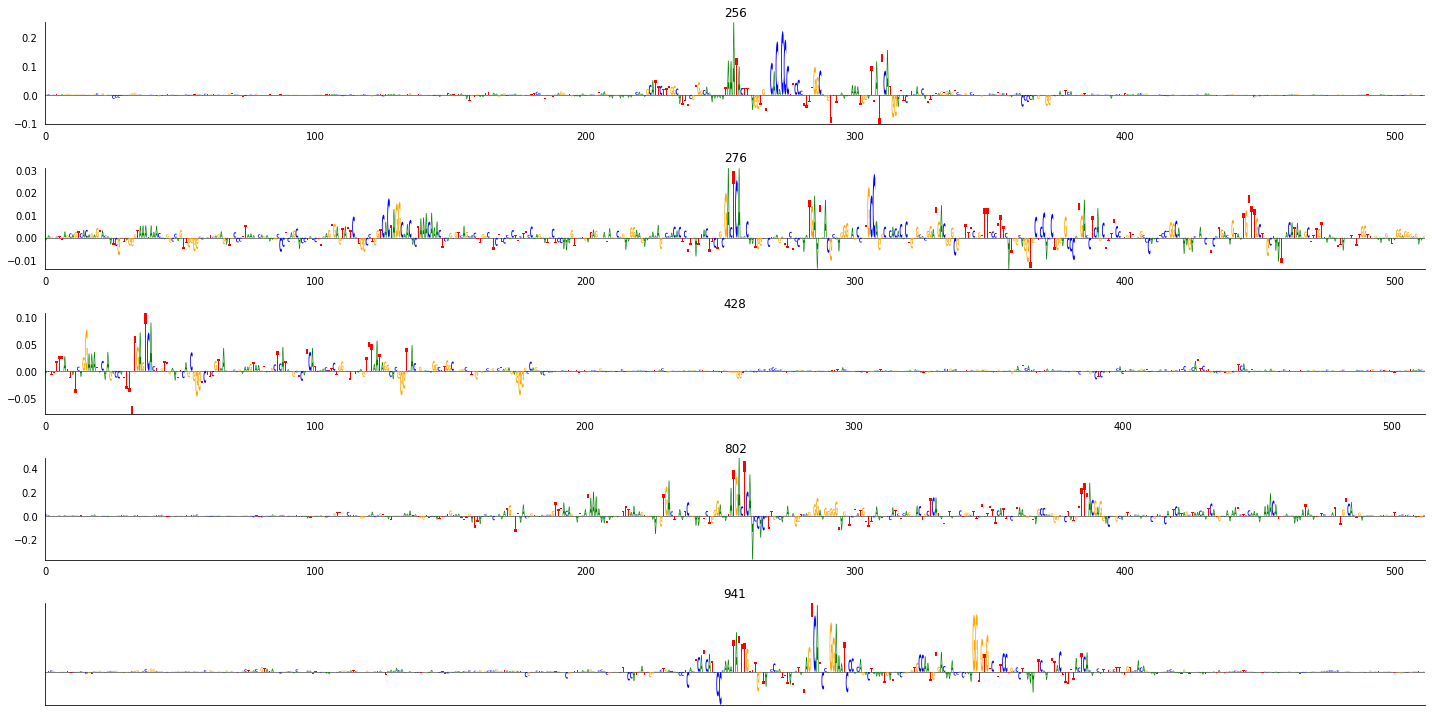

In [48]:
saliency_cell_line_dir = utils.make_dir('tutorial_outputs/saliency_maps')
sets_of_ids = {k:np.argwhere(v).flatten()[:5] for k, v  in conditions.items()}

for label,selected_sample_ids in sets_of_ids.items():
    output_path = os.path.join(saliency_cell_line_dir, label+'.svg')
    print(output_path)
    explainer = saliency_embed.Explainer(model, class_index=cell_line)
    X_sample = thresholded_X[selected_sample_ids]
    saliency_scores = explainer.saliency_maps(X_sample)
    saliency_embed.plot_saliency_logos_oneplot(saliency_scores, X_sample, window=256, 
                                    titles = selected_sample_ids,
                                    filename=output_path)